<a href="https://colab.research.google.com/github/Totti00/VA_Project/blob/main/VA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First commit

In [4]:
!wget https://www.dropbox.com/scl/fi/llieye7mvxzy83g4ggr00/san-vitale-challenge-dataset.zip?rlkey=cggsno35heeu0olidgkmrhaw4&dl=0
!unzip -q san-vitale-challenge-dataset.zip?rlkey=cggsno35heeu0olidgkmrhaw4
!rm san-vitale-challenge-dataset.zip?rlkey=cggsno35heeu0olidgkmrhaw4

--2024-02-05 15:19:21--  https://www.dropbox.com/scl/fi/llieye7mvxzy83g4ggr00/san-vitale-challenge-dataset.zip?rlkey=cggsno35heeu0olidgkmrhaw4
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd9ef75496fc64ae758ad1ad148.dl.dropboxusercontent.com/cd/0/inline/CMv4ZCjkHRiw5lJHWhMh9X_7B4XXMayLV3cOJF-VvfqYQQ6kBvj9YMA0sS_UuBRq8a_HiIR1sk-7NzLil-N82_-bkRm5nDyt5_SXmLdHQ6K82lEL5-rz3dGZQlYu24D9G4276WLbtvXa9SwH-AyfUnJI/file# [following]
--2024-02-05 15:19:22--  https://ucd9ef75496fc64ae758ad1ad148.dl.dropboxusercontent.com/cd/0/inline/CMv4ZCjkHRiw5lJHWhMh9X_7B4XXMayLV3cOJF-VvfqYQQ6kBvj9YMA0sS_UuBRq8a_HiIR1sk-7NzLil-N82_-bkRm5nDyt5_SXmLdHQ6K82lEL5-rz3dGZQlYu24D9G4276WLbtvXa9SwH-AyfUnJI/file
Resolving ucd9ef75496fc64ae758ad1ad148.dl.dropboxusercontent.com (ucd9ef75496fc64ae758ad1ad148.dl.dropboxusercontent.com).

In [7]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [16]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [15]:
pip install fastapi

In [14]:
!pip install kaleido

In [13]:
!pip install python-multipart

In [12]:
!pip install uvicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00


In [19]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [22]:
import os
from PIL import Image
import torch
import cv2
from matplotlib import pyplot as plt
import numpy as np
import supervision as sv

def resize_img(img_path, input_size):
  my_image = plt.imread(img_path)
  if max(my_image.shape[0], my_image.shape[1]) > input_size:
    if my_image.shape[0] >= my_image.shape[1]:
      height = input_size
      width = int(my_image.shape[1] * input_size / my_image.shape[0])
    else:
      width = input_size
      height = int(my_image.shape[0] * input_size / my_image.shape[1])
    my_image = cv2.resize(my_image, (width, height), interpolation=cv2.INTER_LINEAR)
  plt.imsave(img_path, my_image)

def pad_img(img_path, input_size):
  my_image = plt.imread(img_path)
  pad_width = input_size - my_image.shape[0]
  pad_height = input_size - my_image.shape[1]
  my_padded_image = np.pad(my_image, ((0, pad_width), (0, pad_height), (0, 0)), 'constant')
  plt.imsave(img_path, my_padded_image)

In [34]:
#im1 = Image.open(r'/content/dataset/train/1/387.png')

resize_img('/content/dataset/train/6/A.png', 1504)

#im1.save('/content/dataset/train/1/test2.jpeg', dpi=(256,256))


In [18]:
HOME = os.getcwd()
print("HOME:", HOME)

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

HOME: /content
/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [19]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [20]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [35]:
mask_generator = SamAutomaticMaskGenerator(sam)
IMAGE_NAME = "A.png"
IMAGE_PATH = os.path.join(HOME, "dataset/train/6/", IMAGE_NAME)
#img=cv2.imread(IMAGE_PATH)
#print(img.shape)
print(IMAGE_PATH)

/content/dataset/train/6/A.png


In [36]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

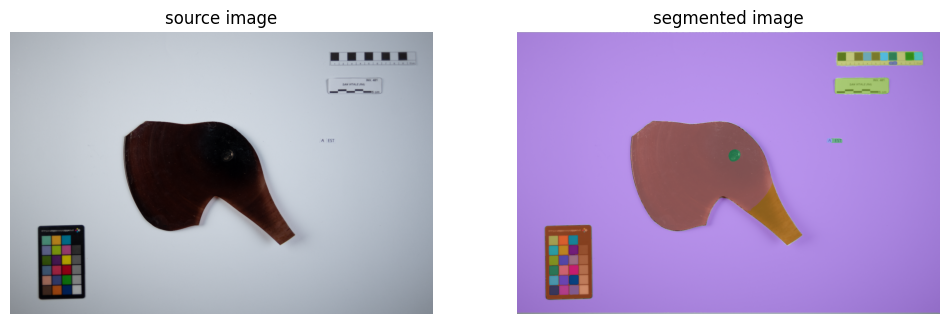

In [37]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [41]:
plt.imsave('dataset/train/6/A_segmented.png', annotated_image)

AttributeError: module 'supervision' has no attribute 'save_image'